# Predictions

In this script we can obtain the predictions of the model trying to determine the results from the validation test of any model

In [1]:
from google.colab import drive

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Paths to the dataset and selecting the model to employ

In [2]:
# Paths to your dataset

ModelFolder = ('/content/drive/MyDrive/Research/HLB Classification/Arquitecturas/ResNet50')
ImagesFolder = ('/content/drive/MyDrive/Research/HLB Classification/Database')
ImagesSplittedFolder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted')

Training_Folder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted/train')
Validation_Folder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted/val')

os.chdir(ModelFolder)

# Load the trained model
model = tf.keras.models.load_model('01_ResNet50_FineTuning.keras')

ModelName = 'ResNet50'

In [3]:
# Define the image dimensions
Batch_Size = 32
Img_Size = (224, 224)

Train_Dataset = image_dataset_from_directory(Training_Folder,
                                             shuffle = True,
                                             batch_size = Batch_Size,
                                             image_size = Img_Size)

Validation_Dataset_Original = image_dataset_from_directory(Validation_Folder,
                                             shuffle = True,
                                             batch_size = Batch_Size,
                                             image_size = Img_Size)

Found 622 files belonging to 2 classes.
Found 157 files belonging to 2 classes.


Creating the loop ot save the results of each batch

In [4]:

# Initialize lists to store predictions and labels
all_predictions = []
all_labels = []

# Iterate over the test dataset in batches
for image_batch, label_batch in Validation_Dataset_Original.as_numpy_iterator():
    # Make predictions on the batch
    predictions = model.predict_on_batch(image_batch).flatten()

    # Apply sigmoid and threshold
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)

    # Append predictions and labels to lists
    all_predictions.extend(predictions.numpy())
    all_labels.extend(label_batch)

Creating the confusion matrix and calculating all the metrics

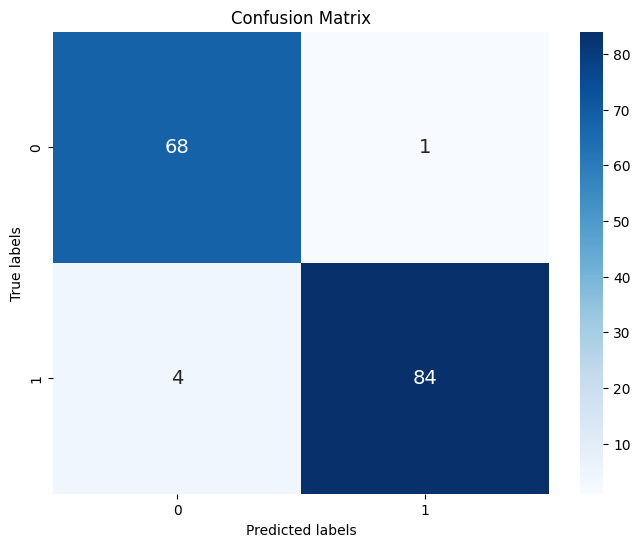

Accuracy: 0.9682
Balanced Accuracy: 0.9663
Precision: 0.9882
Specificity: 0.9855
Recall: 0.9545
Negative Predicted Value: 0.9444
F1 Score: 0.9711
Matthews correlation coefficient: 0.9364
Geometric mean: 0.9712
ROC Curve:0.970
Prevalence: 0.5414


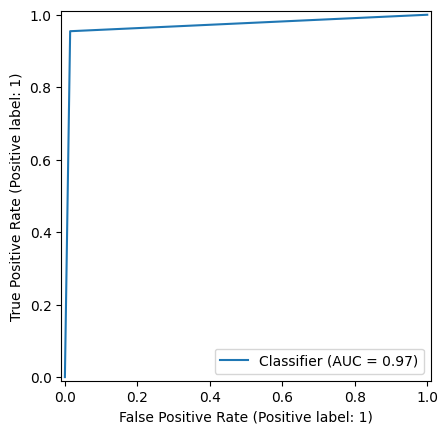

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score


# Calculate confusion matrix
conf_mat = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d',
            annot_kws={'size': 14})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(ModelFolder, '01 05 Confusion Matrix.jpg'))

plt.show()

# Calculate metrics
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]
Positives = TP + FP
Negatives = TN + FN

accuracy = (TP + TN) / (TP + TN + FP + FN)
BalAcc = ((TP/Positives)+ (TN/Negatives)) / 2
precision = TP / (TP + FP)
specificity = TN / (TN + FP)
recall = TP / (TP + FN)
NegPredVal = TN / (TN + FN)
MCC = ((TP * TN) - (FP * FN)) / np.sqrt((Positives) * (TP + FN) * (TN + FP) * (Negatives))
Gmean = TP / np.sqrt(Positives * (TP+FN))
f1_score = 2 * precision * recall / (precision + recall)
#ROCvalue = recall + 1 - specificity
roc_auc = roc_auc_score(all_labels, all_predictions)
prevalence = Positives / (Positives + Negatives)

RocCurveDisplay.from_predictions(all_labels, all_predictions)
plt.savefig(os.path.join(ModelFolder, '01 06 ROC Curve.jpg'))

print(f'Accuracy: {accuracy:.4f}')
print(f'Balanced Accuracy: {BalAcc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Negative Predicted Value: {NegPredVal:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'Matthews correlation coefficient: {MCC:.4f}')
print(f'Geometric mean: {Gmean:.4f}')
print(f'ROC Curve:{roc_auc:.3f}')
print(f'Prevalence: {prevalence:.4f}')

In [6]:
ResultsValues = pd.DataFrame({'Model:': ['Variables',
                                            'Accuracy',
                                            'Balanced Accuracy',
                                            'Precision',
                                            'Specificity',
                                            'Recall',
                                            'Negative Predicted Value',
                                            'F1 Score',
                                            'Matthews correlation coefficient',
                                            'Geometric mean',
                                            'AUC ROC Curve',
                                            'Prevalence'],
                              ModelName: ['Value',
                                        round(accuracy, 4),
                                        round(BalAcc, 4),
                                        round(precision, 4),
                                        round(specificity, 4),
                                        round(recall, 4),
                                        round(NegPredVal, 4),
                                        round(f1_score, 4),
                                        round(MCC, 4),
                                        round(Gmean, 4),
                                        round(roc_auc, 3),
                                        round(prevalence, 4),]})

ResultsValues.to_csv(os.path.join(ModelFolder, '01 07 Results.csv'), index=False)